In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import svm

In [2]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv")
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv")
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv")
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv")
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv")
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv")

In [3]:
dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

In [4]:
def process_data(new_data):
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]

for data in dataset:
    process_data(data)

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [5]:
data = PPP_data.copy()

In [6]:
float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'shareborder', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'lendingtype']
ordinal_value = ['incomelevel']
float_value_2 = ['period', 
                 'realphysicalassets', 
                 'investment_real', 
                 'GDP', 
                 'population', 
                 'CPI2019',
                 'bordercountries', 
                 'private', 
                 'physical', 
                 'period',
                 'investment', 
                 'pcapacity']
data.drop(columns=['bid_crit', 
                   'country', 
                   'regionname',
                   'adminregion',
                   'region',
                   'Description',
                   'adminregionname',
                   'incomelevelname',
                   'income',
                   'lendingtypename',
                   'BS',
                   'PCO',
                   'TIGS'], inplace=True)

data.replace('..', np.nan, inplace=True)
data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

for float_column in float_value + float_value_2:
    data[float_column] = data[float_column].astype(float)

In [7]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 2, 
          'LMC': 3, 
          'UMC': 4, 
          np.nan: 0}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)
#convert the FCY to datetime
X.loc[:, 'FCY'] = pd.DatetimeIndex(X.FCY).year
predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=123, stratify=y, shuffle=True)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
#get the corrlation that larger than a threshold, for numeric data.
def find_correlation(data, threshold):
    correlated_column = defaultdict(list)
    correlation_matrix = data.corr()
    for i, row in correlation_matrix.iterrows():
        for column in correlation_matrix.columns:
            if (abs(row[column]) > threshold) & (abs(row[column]) != 1.0):
                correlated_column[i].append(column)
    return correlated_column

In [9]:
correlated_column = find_correlation(X_train, 0.6)
column_to_be_dropped = ['CPI2019', 
                        'physical', 
                        'investment', 
                        'GDP', 
                        'realphysicalassets', 
                        'life_expectnacy', 
                        'exports_as_GDP', 
                        'control_of_corruption',
                        'domestic_credit_to_private', 
                        'electric_consumption']
X_train.drop(columns=column_to_be_dropped, inplace=True)
X_test.drop(columns=column_to_be_dropped, inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


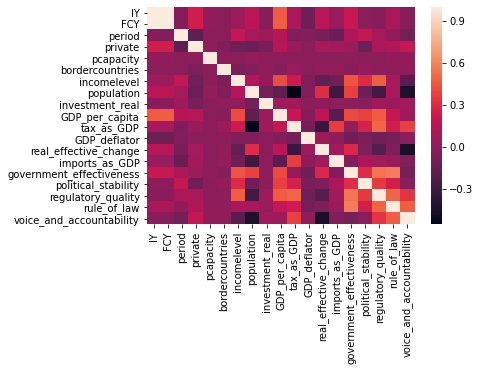

In [78]:
sns.heatmap(X_train.corr().iloc[:28, 0:28])

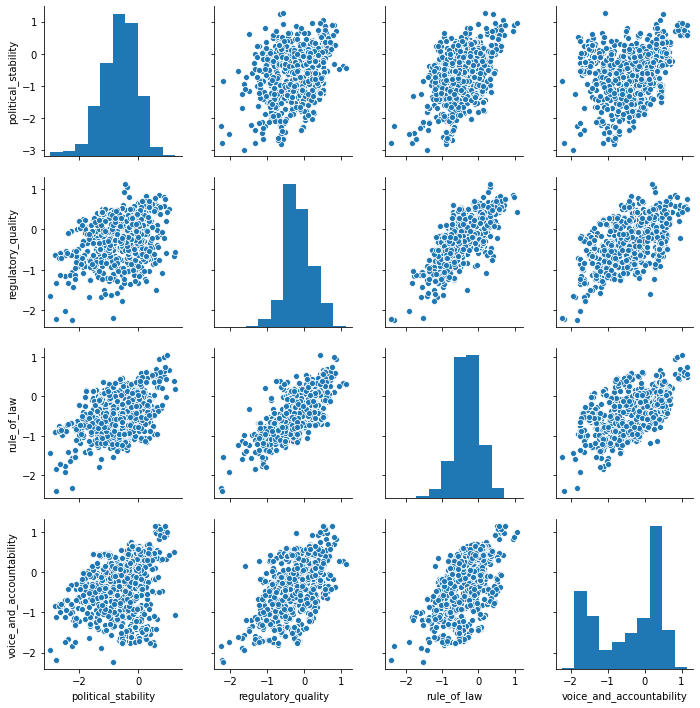

In [132]:
sns.pairplot(X_train.iloc[:, 34:38])

In [10]:
# one factor
def fill_missing_float_1(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[train[group_list[0]] == i[0], column]
        test_filled = test.loc[test[group_list[0]] == i[0], column]
        train.loc[train[group_list[0]] == i[0], column] = train_filled.fillna(rows[column])
        test.loc[test[group_list[0]] == i[0], column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test  

In [11]:
# two factors.
def fill_missing_float_2(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test        

In [12]:
# two factors.
def fill_missing_float_3(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

In [13]:
#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal(train_dataset, test_dataset, column_name):
    train_data = train_dataset.copy()
    test_data = test_dataset.copy()
    mode_in_train = train_data.groupby('countrycode')[column_name].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column_name]) == np.ndarray:
            mode_in_train.loc[index, column_name] = train_data[column_name].mode()[0]
    countrycode_in_train = train_data.countrycode.unique()
    countrycode_in_test = train_data.countrycode.unique()
    
    for country in countrycode_in_train:
        train_data.loc[train_data.countrycode==country, column_name] = train_data.loc[train_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])

    for country in countrycode_in_test:
        if country in countrycode_in_train:
            test_data.loc[test_data.countrycode==country, column_name] = test_data.loc[test_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])
    test_data.loc[test_data[column_name].isnull(), column_name] = test_data.loc[test_data[column_name].isnull(), column_name].fillna(test_data[column_name].mode()[0])
    return train_data, test_data

In [83]:
X_train.shape

(5251, 35)

In [14]:
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'period')
X_train, X_test = fillna_for_nominal(X_train, X_test, 'GGC')
X_train, X_test = fill_missing_float_3(X_train, X_test, ['stype', 'ssector', 'countrycode'], 'private')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['countrycode', 'ssector'], 'pcapacity')
X_train, X_test = fillna_for_nominal(X_train, X_test, 'PRS')
X_train, X_test = fillna_for_nominal(X_train, X_test, 'lendingtype')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'population')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'investment_real')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'GDP_per_capita')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'tax_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'GDP_deflator')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'real_effective_change')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'imports_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'government_effectiveness')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'political_stability')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'regulatory_quality')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'rule_of_law')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['countrycode'], 'voice_and_accountability')

In [15]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [16]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object])
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]

In [17]:
#scaling data
scaler = StandardScaler()
column_name = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=column_name)
X_test = pd.DataFrame(X_test, columns=column_name)

In [18]:
#to resample data
X_train.loc[:, 'status_n'] = y_train

In [19]:
#begin to resample
majority_data = X_train[X_train.status_n==0]
minority_data = X_train[X_train.status_n==1]

minority_upsampled = resample(minority_data, 
                              replace=True,
                              n_samples=majority_data.shape[0],
                              random_state=123)
upsampled_data = pd.concat([majority_data, minority_upsampled])

In [20]:
X_train_upsample = upsampled_data[upsampled_data.columns[upsampled_data.columns!='status_n']]
y_train_upsample = upsampled_data['status_n']

In [21]:
X_train_upsample.shape

(10094, 234)

In [22]:
y_train_upsample.shape

(10094,)

In [23]:
X_train.shape

(5251, 235)

In [21]:
#SMOTE
X_smote = X_train.copy()
y_smote = y_train.copy()
X_smote.drop(columns=['status_n'], inplace=True)

sm = SMOTE(random_state=1)
X_train_smote, y_train_smote = sm.fit_resample(X_smote, y_smote)

In [154]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [500, 600, 700],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [28, 30, 31],
              'min_samples_split': [2, 3],
              'min_samples_leaf': [2, 3]}
grid = GridSearchCV(clf, 
                    param_grid, 
                    refit=True, 
                    verbose=3, 
                    n_jobs=-1)

grid.fit(X_train_upsample, y_train_upsample)
#clf and upsample
pred_clf_upsample = cross_val_predict(grid.best_estimator_,
                                      X_test,
                                      y_test,
                                      method='predict_proba',
                                      cv=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.9min finished


GridSearchCV(estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [28, 30, 31],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [500, 600, 700]},
             verbose=3)

In [167]:
#clf and smote
grid = GridSearchCV(clf, 
                    param_grid, 
                    refit=True, 
                    verbose=3, 
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)

pred_clf_smote = cross_val_predict(grid.best_estimator_,
                                   X_test,
                                   y_test,
                                   method='predict_proba',
                                   cv=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 11.9min finished


GridSearchCV(estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [28, 30, 31],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [500, 600, 700]},
             verbose=3)

In [22]:
#svm, and upsample
svm_model_upsample = svm.SVC(probability=True)
param_grid = {'C': [100, 150],  
              'gamma': [1], 
              'kernel': ['rbf']} 
grid = GridSearchCV(svm_model_upsample, 
                    param_grid, 
                    refit=True, 
                    verbose=3, 
                    n_jobs=-1)
grid.fit(X_train_upsample, y_train_upsample)
pred_svm_upsample = cross_val_predict(grid.best_estimator_,
                                      X_test,
                                      y_test,
                                      method='predict_proba',
                                      cv=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.8min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished


In [23]:
grid.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
#svm and upsample
grid.fit(X_train_smote, y_train_smote)
pred_svm_smote = cross_val_predict(grid.best_estimator_,
                                   X_test,
                                   y_test,
                                   method='predict_proba',
                                   cv=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [23]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return (fpr, tpr, thresholds)

(array([0.        , 0.        , 0.00169205, 0.00169205, 0.00282008,
        0.00282008, 0.00451213, 0.00451213, 0.00507614, 0.00507614,
        0.00620417, 0.00620417, 0.00733221, 0.00733221, 0.00789622,
        0.00789622, 0.01466441, 0.01466441, 0.01579244, 0.01579244,
        0.01748449, 0.01748449, 0.02199662, 0.02199662, 0.02256063,
        0.02256063, 0.02481669, 0.02481669, 0.02650874, 0.02650874,
        0.02989284, 0.02989284, 0.03722504, 0.03722504, 0.04060914,
        0.04060914, 0.04230118, 0.04230118, 0.04624929, 0.04624929,
        0.04963339, 0.04963339, 0.05640158, 0.05640158, 0.05922166,
        0.05922166, 0.05978567, 0.05978567, 0.06034969, 0.06034969,
        0.06373378, 0.06373378, 0.0642978 , 0.0642978 , 0.06486182,
        0.06486182, 0.06598985, 0.06598985, 0.07106599, 0.07106599,
        0.08009024, 0.08009024, 0.08347434, 0.08347434, 0.08629442,
        0.08629442, 0.09193457, 0.09193457, 0.10377891, 0.10377891,
        0.10547095, 0.10547095, 0.10885505, 0.10

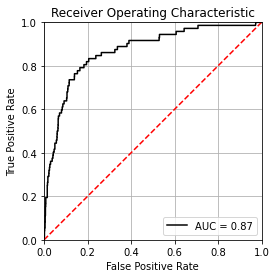

In [159]:
plot_roc(y_test, pred_clf_upsample[:,1])

(array([0.        , 0.        , 0.00169205, 0.00169205, 0.00282008,
        0.00282008, 0.00451213, 0.00451213, 0.00507614, 0.00507614,
        0.00620417, 0.00620417, 0.00733221, 0.00733221, 0.00789622,
        0.00789622, 0.01466441, 0.01466441, 0.01579244, 0.01579244,
        0.01748449, 0.01748449, 0.02199662, 0.02199662, 0.02256063,
        0.02256063, 0.02481669, 0.02481669, 0.02650874, 0.02650874,
        0.02989284, 0.02989284, 0.03722504, 0.03722504, 0.04060914,
        0.04060914, 0.04230118, 0.04230118, 0.04624929, 0.04624929,
        0.04963339, 0.04963339, 0.05640158, 0.05640158, 0.05922166,
        0.05922166, 0.05978567, 0.05978567, 0.06034969, 0.06034969,
        0.06373378, 0.06373378, 0.0642978 , 0.0642978 , 0.06486182,
        0.06486182, 0.06598985, 0.06598985, 0.07106599, 0.07106599,
        0.08009024, 0.08009024, 0.08347434, 0.08347434, 0.08629442,
        0.08629442, 0.09193457, 0.09193457, 0.10377891, 0.10377891,
        0.10547095, 0.10547095, 0.10885505, 0.10

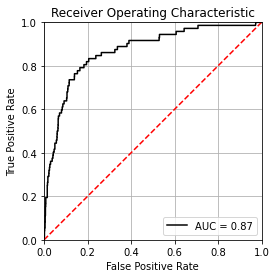

In [172]:
plot_roc(y_test, pred_clf_smote[:,1])

(array([0.00000000e+00, 5.64015792e-04, 1.12803158e-03, 1.12803158e-03,
        1.69204738e-03, 1.69204738e-03, 3.38409475e-03, 3.38409475e-03,
        4.51212634e-03, 4.51212634e-03, 7.33220530e-03, 7.33220530e-03,
        1.46644106e-02, 1.46644106e-02, 1.52284264e-02, 5.41455161e-02,
        5.47095319e-02, 5.58375635e-02, 8.17822899e-02, 8.17822899e-02,
        9.81387479e-02, 9.81387479e-02, 1.14495206e-01, 1.14495206e-01,
        1.15059222e-01, 1.53412296e-01, 1.55668359e-01, 1.57924422e-01,
        1.63000564e-01, 1.63000564e-01, 1.69768754e-01, 1.70896785e-01,
        1.83305133e-01, 1.83305133e-01, 2.13197970e-01, 2.13197970e-01,
        2.21094191e-01, 2.21094191e-01, 2.56627186e-01, 2.56627186e-01,
        3.40665539e-01, 3.40665539e-01, 3.48561760e-01, 3.48561760e-01,
        3.52509870e-01, 3.52509870e-01, 3.65482234e-01, 3.65482234e-01,
        3.68866328e-01, 3.69994360e-01, 3.93683023e-01, 4.33164129e-01,
        4.33164129e-01, 4.34292160e-01, 4.34292160e-01, 4.500846

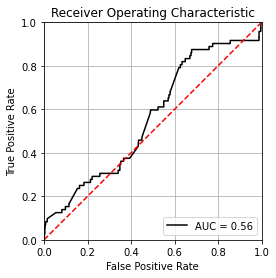

In [24]:
plot_roc(y_test, pred_svm_upsample[:,1])

In [25]:
def plot_recall_precision(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    plt.title('Recall-Precision')
    plt.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.legend(loc = 'lower right')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    return (precision, recall, thresholds)

No handles with labels found to put in legend.


(array([0.04002223, 0.03955432, 0.03957637, ..., 0.5       , 1.        ,
        1.        ]),
 array([1.        , 0.98611111, 0.98611111, ..., 0.01388889, 0.01388889,
        0.        ]),
 array([2.94637390e-05, 3.84615385e-05, 4.14841993e-05, ...,
        5.14596810e-01, 5.16050960e-01, 5.69934176e-01]))

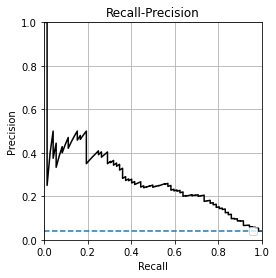

In [161]:
plot_recall_precision(y_test, pred_clf_upsample[:,1])

No handles with labels found to put in legend.


(array([0.04002223, 0.03955432, 0.03957637, ..., 0.5       , 1.        ,
        1.        ]),
 array([1.        , 0.98611111, 0.98611111, ..., 0.01388889, 0.01388889,
        0.        ]),
 array([2.94637390e-05, 3.84615385e-05, 4.14841993e-05, ...,
        5.14596810e-01, 5.16050960e-01, 5.69934176e-01]))

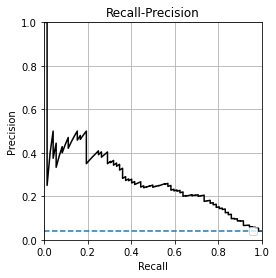

In [173]:
plot_recall_precision(y_test, pred_clf_smote[:,1])

No handles with labels found to put in legend.


(array([0.03913043, 0.03860794, 0.03808487, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.98611111, 0.97222222, ..., 0.        , 0.        ,
        0.        ]),
 array([0.00490716, 0.00551109, 0.0072263 , ..., 0.46089547, 0.49226806,
        0.9641086 ]))

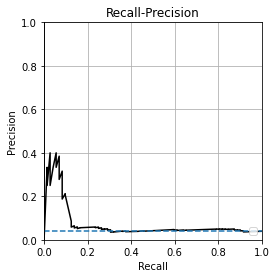

In [26]:
plot_recall_precision(y_test, pred_svm_upsample[:,1])

In [162]:
import seaborn as sns
def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [163]:
confusion_matrix(y_test, pred_clf_upsample[:, 1] > 0.1)

array([[1588,  185],
       [  25,   47]], dtype=int64)

In [174]:
confusion_matrix(y_test, pred_clf_smote[:, 1] > 0.1)

array([[1588,  185],
       [  25,   47]], dtype=int64)

In [192]:
confusion_matrix(y_test, pred_svm_upsample[:, 1] > 0.1)

array([[1678,   95],
       [  47,   25]], dtype=int64)

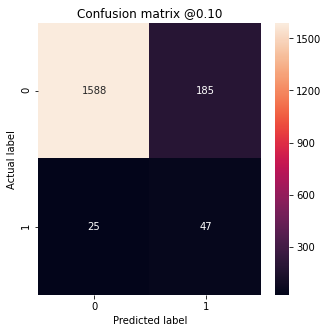

In [175]:
plot_cm(y_test, pred_clf_upsample[:, 1])

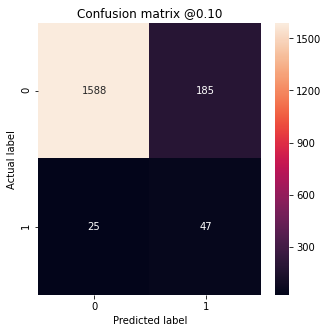

In [176]:
plot_cm(y_test, pred_clf_smote[:, 1])

In [ ]:
#svm


In [327]:
#feature importance
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': grid.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [328]:
fi.head(20)

,feature,importance
8,investment_real,0.084345
4,pcapacity,0.074595
2,period,0.050017
11,GDP_deflator,0.045035
10,tax_as_GDP,0.040508
13,imports_as_GDP,0.039300
9,GDP_per_capita,0.039191
14,government_effectiveness,0.038242
15,political_stability,0.037434
7,population,0.036877
